In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install pandas numpy scikit-learn seaborn matplotlib opencv-python tensorflow keras tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 755.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 167.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 144.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import zipfile

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [4]:
class_names=['FAKE','REAL']
calss_names_labels={class_name:i for i,class_name in enumerate(class_names)}
n_classes=len(class_names)
img_size=(150,150)


In [5]:
def load_the_data():
  zip_path = '/content/drive/MyDrive/real_and_fake_image.zip'

  extract_path = '/content/real_and_fake_image'

  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)

  datasets='/content/real_and_fake_image'
  output=[]
  for dataset in os.listdir(datasets):
    images=[]
    labels=[]
    dataset_path = os.path.join(datasets, dataset)
    for folder in os.listdir(dataset_path):
      label=calss_names_labels[folder]
      folder_path = os.path.join(dataset_path, folder)

      for file in tqdm(os.listdir(folder_path)):

          img_path=os.path.join(folder_path,file)
          image=cv2.imread(img_path)
          if image is None:
              print(" Failed to read:", img_path)
              continue

          image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
          image=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
          image = cv2.resize(image, img_size)



          images.append(image)
          labels.append(label)



    images=np.array(images ,dtype =np.float32)
    labels=np.array(labels,dtype = 'int32')

    output.append((images,labels))


  return output


In [6]:
(train_images, train_labels), (test_images, test_labels)=load_the_data()
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

train_labels = train_labels.squeeze()
test_labels  = test_labels.squeeze()

100%|██████████| 50000/50000 [00:03<00:00, 14391.24it/s]


In [7]:
train_images,train_labels=shuffle(train_images,train_labels,random_state=42)

In [8]:
train_images=train_images/255.0
test_images=test_images/255.0


In [9]:
def display_random_image(class_names,train_images,train_labels):
  index=np.random.randint(train_images.shape[0])
  plt.imshow(train_images[index],cmap='gray')
  plt.grid(False)
  plt.title(f"image is {class_names[train_labels[index]]}")
  plt.xticks([])
  plt.yticks([])
  plt.show()

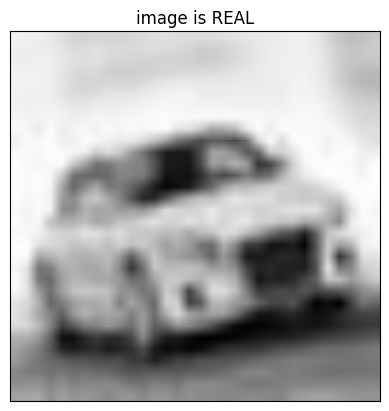

In [10]:
display_random_image(class_names,train_images,train_labels)

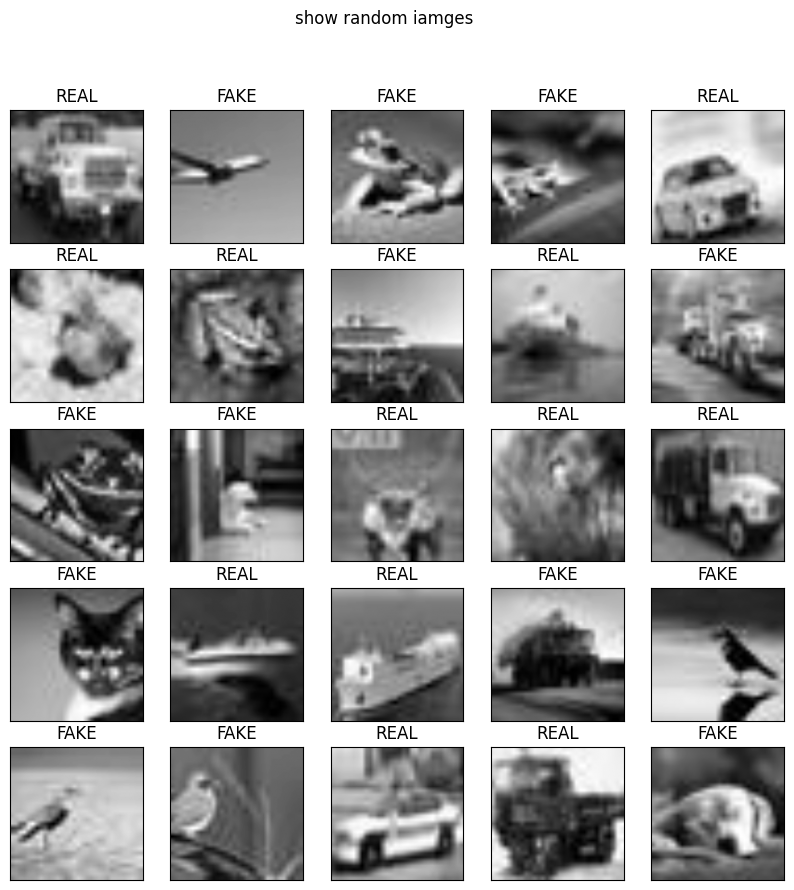

In [11]:
def show_images(class_names,train_images,train_labels):
  fig=plt.figure(figsize=(10,10))
  fig.suptitle("show random iamges")
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.title(class_names[train_labels[i]])
    plt.imshow(train_images[i],cmap='gray')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
  plt.show()
show_images(class_names,train_images,train_labels)

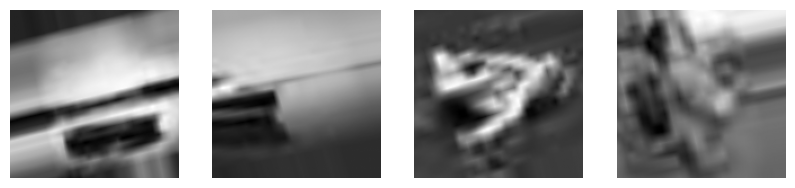

In [12]:
def plot(data_generator,train_images):
  data_generator.fit(train_images)
  image_iterator = data_generator.flow(train_images)
  fig , axes=plt.subplots(1,4,figsize=(10,10))
  for ax in axes:
    betch =next(image_iterator)
    img=betch[0]
    ax.imshow(img,cmap='gray')
    ax.axis('off')
  plt.show()


data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
plot(data_generator, train_images)


In [13]:
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images,
    train_labels,
    test_size=0.2,
    random_state=42
)

train_gen = data_generator.flow(train_images, train_labels, batch_size=32)
val_gen   = data_generator.flow(val_images, val_labels, batch_size=32)


In [14]:
model=models.Sequential([
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),

    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1,activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

In [16]:
model.fit(
    train_gen,
    epochs=10,
    batch_size=32,
    validation_data=val_gen,
    verbose=1,
    callbacks=[
            EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )]


)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 204s 406ms/step - accuracy: 0.6184 - loss: 0.6361 - val_accuracy: 0.7445 - val_loss: 0.5046
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 201s 402ms/step - accuracy: 0.7517 - loss: 0.5125 - val_accuracy: 0.7750 - val_loss: 0.4869
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 201s 402ms/step - accuracy: 0.7758 - loss: 0.4826 - val_accuracy: 0.7918 - val_loss: 0.4486
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 202s 403ms/step - accuracy: 0.7858 - loss: 0.4640 - val_accuracy: 0.8102 - val_loss: 0.4150
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 201s 401ms/step - accuracy: 0.8074 - loss: 0.4265 - val_accuracy: 0.8295 - val_loss: 0.3848
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 201s 401ms/step - accuracy: 0.8163 - loss: 0.4094 - val_accuracy: 0.8170 - val_loss: 0.4105
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 201s 403ms/step - accuracy: 0.8235 - loss: 0.3901 - val_accuracy: 0.8443 - val_loss: 0.3488
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 201s 403ms/step - accuracy: 0.8426 - loss: 0.36

In [17]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f"\n Test Accuracy: {test_acc*100:.2f}%")


 Test Accuracy: 90.10%


In [18]:
model.save('fake_img_model.h5')
